In [3]:
import pandas as pd
import pickle
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [4]:
from preprocess import *

## Plotting raw signals

In [5]:
def plot_chest_signals(subject_idx, window_in_sec, shift_in_sec, samp_freq=700):
    
    window_size = int(round(window_in_sec * samp_freq))
    shift = int(round(shift_in_sec * samp_freq))
    
    with open(f'./WESAD/S{subject_idx}/S{subject_idx}.pkl', 'rb') as f:
        data = pickle.load(f, encoding="latin1")
    
    signal = data['signal']['chest']
    baseline_labels = data['label'] == 1
    stress_labels = data['label'] == 2
    
    baseline_signal = {}
    stress_signal = {}
    
    for k in signal:
        
        if k == 'ACC':
            continue
        else:
            baseline_signal[k] = signal[k][baseline_labels].squeeze()
            stress_signal[k] = signal[k][stress_labels].squeeze()
    
    baseline_mean, baseline_std = get_mean_std(baseline_signal, window_size, shift)
    stress_mean, stress_std = get_mean_std(stress_signal, window_size, shift)
    
#     print(baseline_mean)
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 14))
    plt.subplots_adjust(hspace=0.5) 
    axes = axes.reshape(5, 2)
    
    
    signal_names = list(baseline_mean.keys())
    
    for i in range(5):
        
        ax = axes[i, 0]
        mean_vals = baseline_mean[signal_names[i]]
        std_vals = baseline_std[signal_names[i]]
        ax.plot(np.arange(len(mean_vals)), mean_vals, color='blue')
        ax.fill_between(np.arange(len(mean_vals)), mean_vals-std_vals, mean_vals+std_vals, color='blue', alpha=0.21)
        
        ax = axes[i, 1]
        mean_vals = stress_mean[signal_names[i]]
        std_vals = stress_std[signal_names[i]]
        ax.plot(np.arange(len(mean_vals)), mean_vals, color='red')
        ax.fill_between(np.arange(len(mean_vals)), mean_vals-std_vals, mean_vals+std_vals, color='red', alpha=0.21)
        
        ax_left, ax_right = axes[i]
        row_x_center = (ax_left.get_position().x0 + ax_right.get_position().x1) / 2
        row_y_top = ax_left.get_position().y1  # top of the row (same for both axes)
        
        fig.text(row_x_center, row_y_top+0.01, signal_names[i],
             ha="center", va="bottom", fontsize=14)
        
#     plt.tight_layout()

            
def get_mean_std(signal, window_size, shift):
    
    sig_len = len(signal[list(signal.keys())[0]])
    start_idxs = np.arange(start=0, stop=sig_len-window_size, step=shift)
    
    signal_mean = {}
    signal_std = {}
    
    for k in signal:
        mean_vals = np.zeros(len(start_idxs))
        std_vals = np.zeros(len(start_idxs))
        
        for i, s_idx in enumerate(start_idxs):
            mean_vals[i] = np.mean(signal[k][s_idx:s_idx+window_size])
            std_vals[i] = np.std(signal[k][s_idx:s_idx+window_size])
        
        signal_mean[k] = mean_vals
        signal_std[k] = std_vals
    
    return signal_mean, signal_std

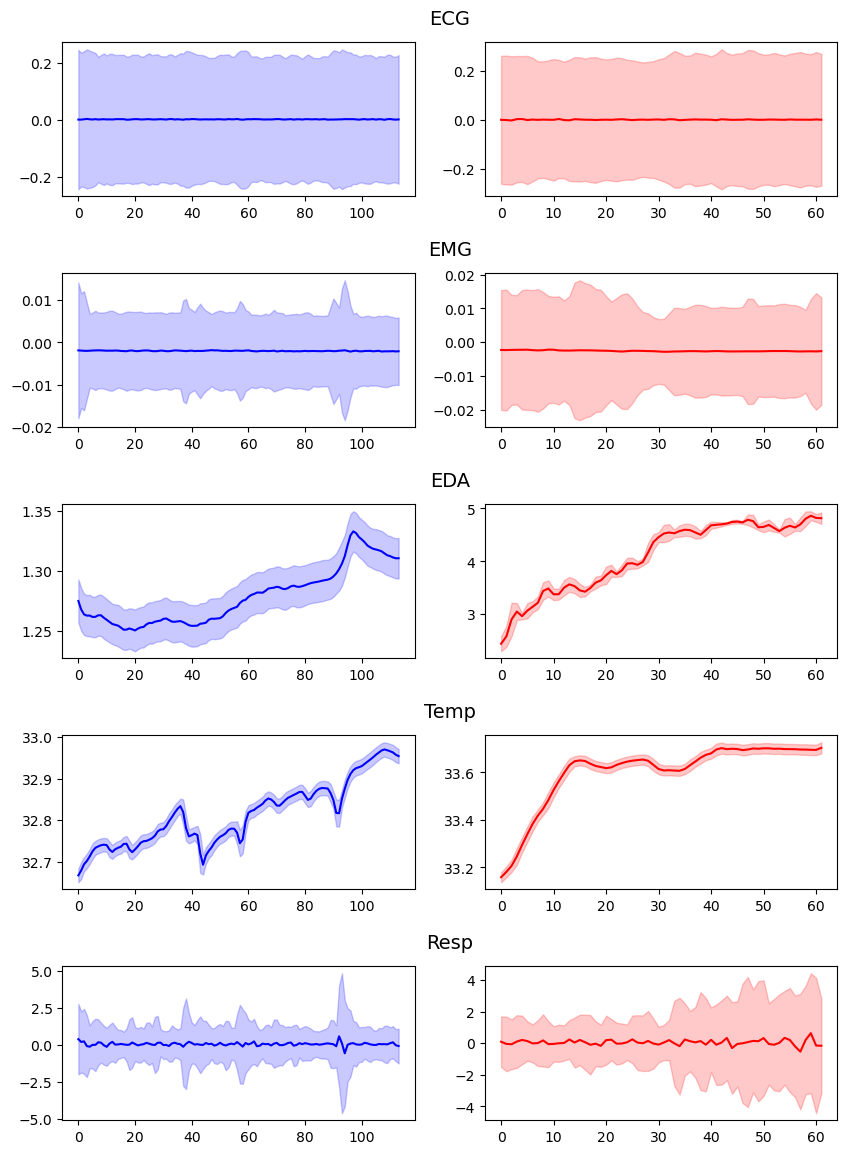

In [6]:
plot_chest_signals(4,20,10)

## Plotting feature correlation for chest features

In [57]:
feature_dict = {'EDA': {'SCL' : ['mean', 'std', 'slope'], 'SCR' : ['mean', 'max', 'counts']},
                'ECG' : ['mean_rate', 'std_rate', 'inter_peak_time', 'RMSSD', 'SDNN'],
                'Temp': ['mean', 'std', 'min','max', 'slope']}
# ,
                # 'Resp': {'Amp' : ['mean_rate', 'mean', 'std', 'SDNN'], 'RVT' : ['mean']}}

In [58]:
sampling_freq_dict = {'EDA': 700, 'ECG': 700, 'Temp': 700, 'Resp':700}

In [59]:
train_df_chest, test_data_list_chest = get_train_test_data(test_subjects=[14,15,16,17], modality='chest', window_in_sec=30, shift_in_sec=15, feature_dict=feature_dict, sampling_freq_dict=sampling_freq_dict, calibration_frac=0.25)

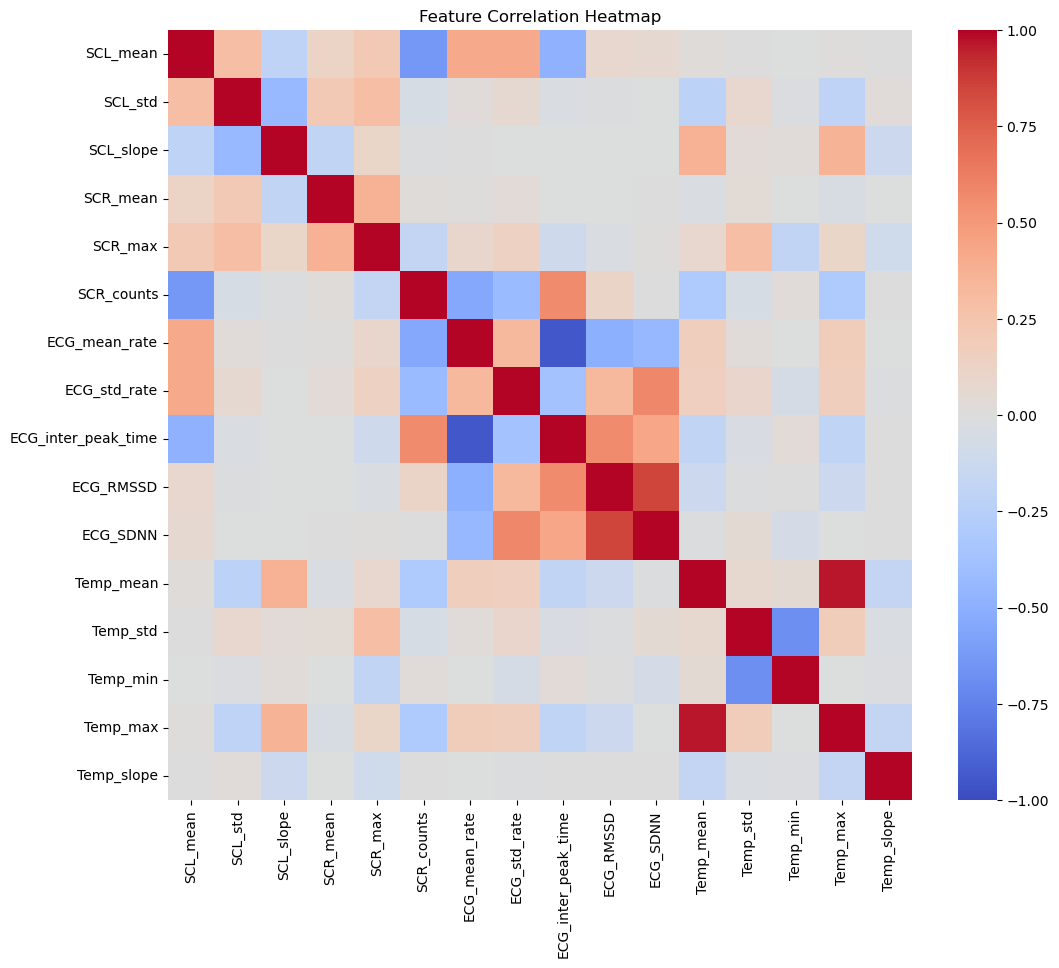

In [60]:
feature_cols = [c for c in train_df_chest.columns if c not in ['label']]
corr = train_df_chest[feature_cols].corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

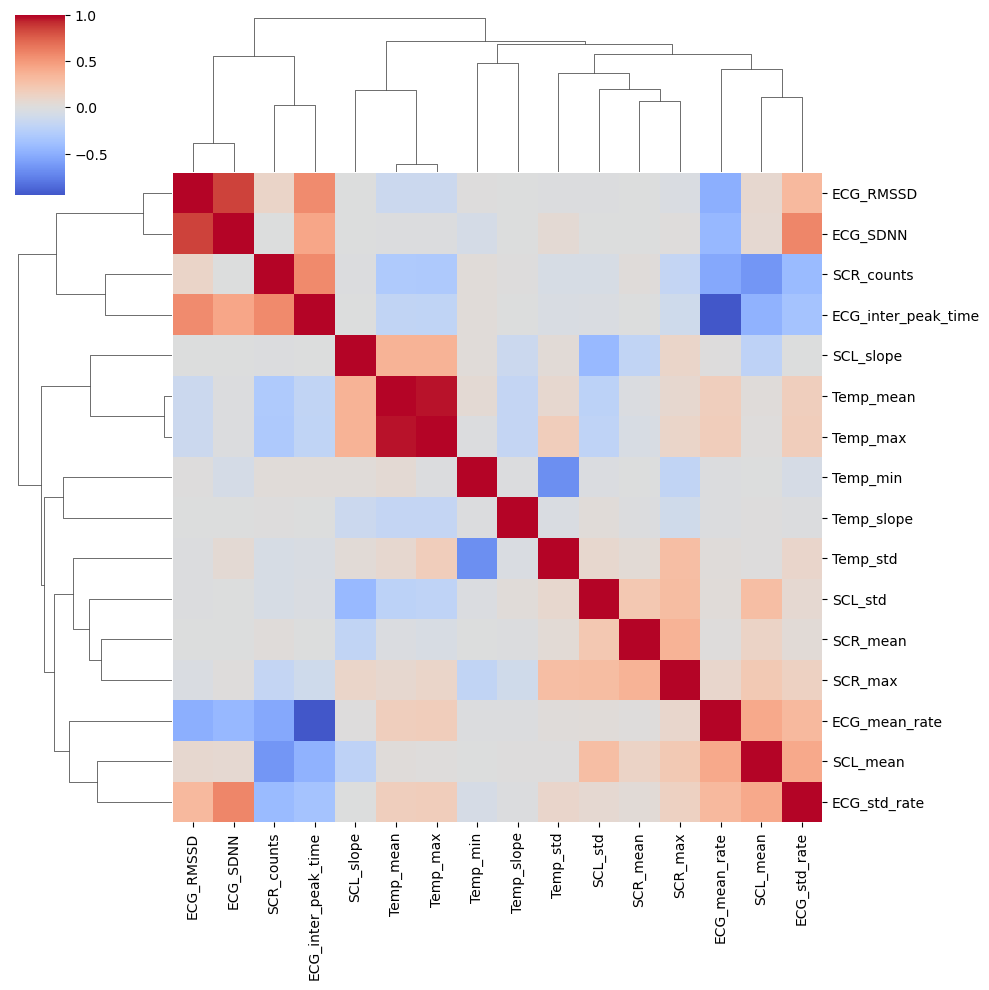

In [61]:
sns.clustermap(corr, cmap='coolwarm', center=0)

In [62]:
train_df_chest

,SCL_mean,SCL_std,SCL_slope,SCR_mean,SCR_max,SCR_counts,ECG_mean_rate,ECG_std_rate,ECG_inter_peak_time,ECG_RMSSD,ECG_SDNN,Temp_mean,Temp_std,Temp_min,Temp_max,Temp_slope,label
0,2.989019,4.186642,-4.054810,3.980034e+00,1.418187,-1.586536,4.100195,1.618015,-3.796571,-0.355088,0.802853,0.219164,-0.291502,0.429707,0.122102,0.071083,0
1,2.733074,2.866620,-2.827975,3.185233e+00,0.765704,-1.266956,3.129103,3.026266,-2.835005,0.818937,2.496443,0.237849,-0.259095,0.429707,0.133675,-0.004504,0
2,2.542299,1.616158,-1.649444,1.146835e+00,0.585638,-1.693062,1.654596,2.905640,-1.471185,2.398663,2.883102,0.185911,-0.090280,0.310695,0.133675,-0.383987,0
3,2.356295,2.452437,-2.473468,-3.390805e-01,0.276121,-1.373483,-0.021232,1.436123,0.107265,1.542191,1.609257,0.081556,-0.176817,0.226594,0.103792,-0.297405,0
4,2.151675,2.178531,-2.206833,-9.703877e-01,-0.190679,-1.586536,0.485320,1.244021,-0.476071,0.223877,1.147727,0.008302,-0.271460,0.164296,-0.053159,-0.196441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1.832928,0.005965,-0.001043,-6.294851e-07,-0.002347,-8.727273,10.031884,5.246915,-66.340576,12.483225,28.964620,0.776840,0.001482,0.793575,0.736594,-0.000131,1
1305,1.809272,0.014874,-0.002074,4.197549e-07,-0.002593,-1.727273,8.004734,1.203830,-58.302383,-2.217351,0.488189,0.786778,-0.000216,0.747768,0.751914,-0.000730,1
1306,1.800310,0.006260,0.001093,-1.312924e-06,0.007839,-14.727273,9.010736,1.299550,-64.820819,13.564371,0.939088,0.789650,-0.000336,0.747768,0.751914,-0.000873,1
1307,1.800372,0.002797,-0.000400,-1.543418e-06,0.006846,-13.727273,9.633954,6.711178,-63.178160,37.560481,25.788155,0.809277,0.007088,0.772182,0.779471,0.001444,1


## Plotting feature correlation for wrist features

In [12]:
feature_dict = {'BVP' : ['mean_rate', 'std_rate', 'inter_peak_time', 'RMSSD', 'SDNN'],
                'Temp': ['mean', 'std', 'min','max', 'slope']}

In [13]:
sampling_freq_dict = {'EDA' : 4, 'BVP':64, 'Temp':4}

In [14]:
train_df_wrist, test_data_list_wrist = get_train_test_data(test_subjects=[14,15,16,17], modality='wrist', window_in_sec=60, shift_in_sec=30, feature_dict=feature_dict, sampling_freq_dict=sampling_freq_dict, calibration_frac=0.25)

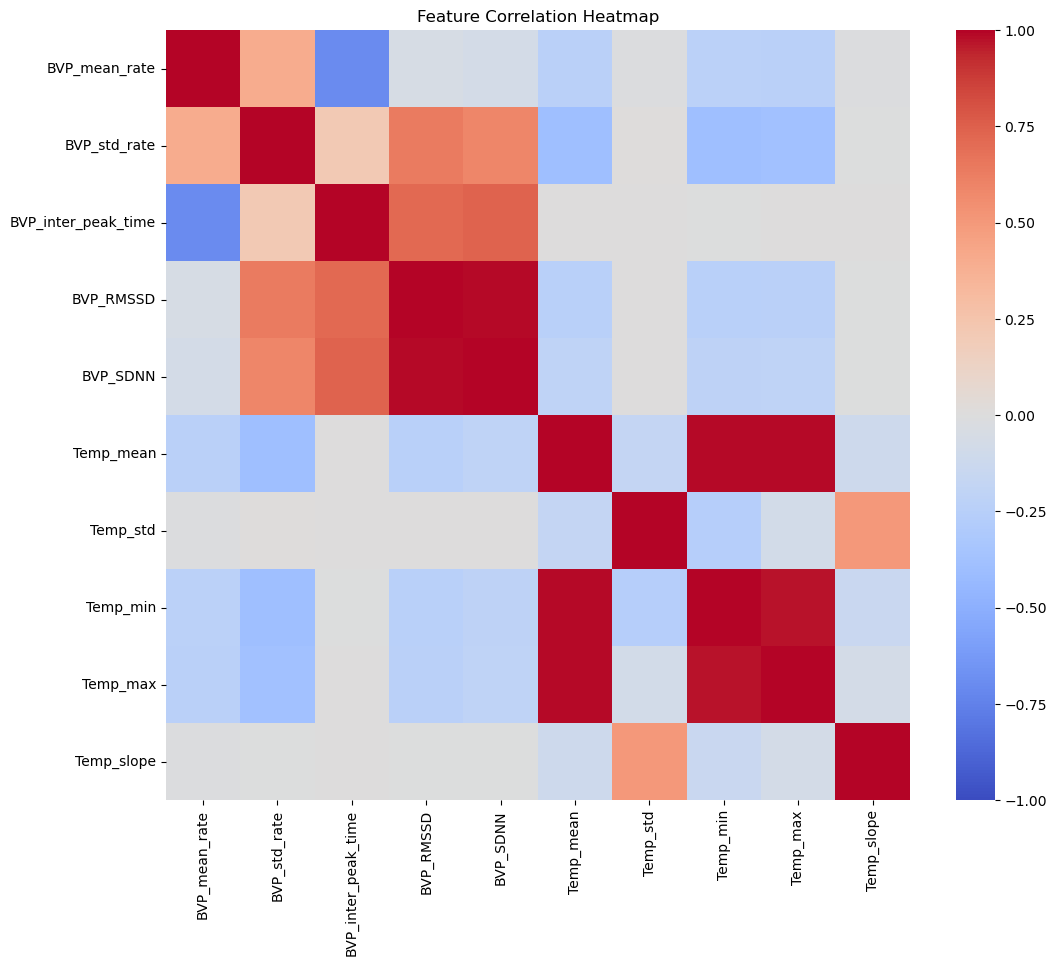

In [15]:
feature_cols = [c for c in train_df_wrist.columns if c not in ['label']]
corr = train_df_wrist[feature_cols].corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

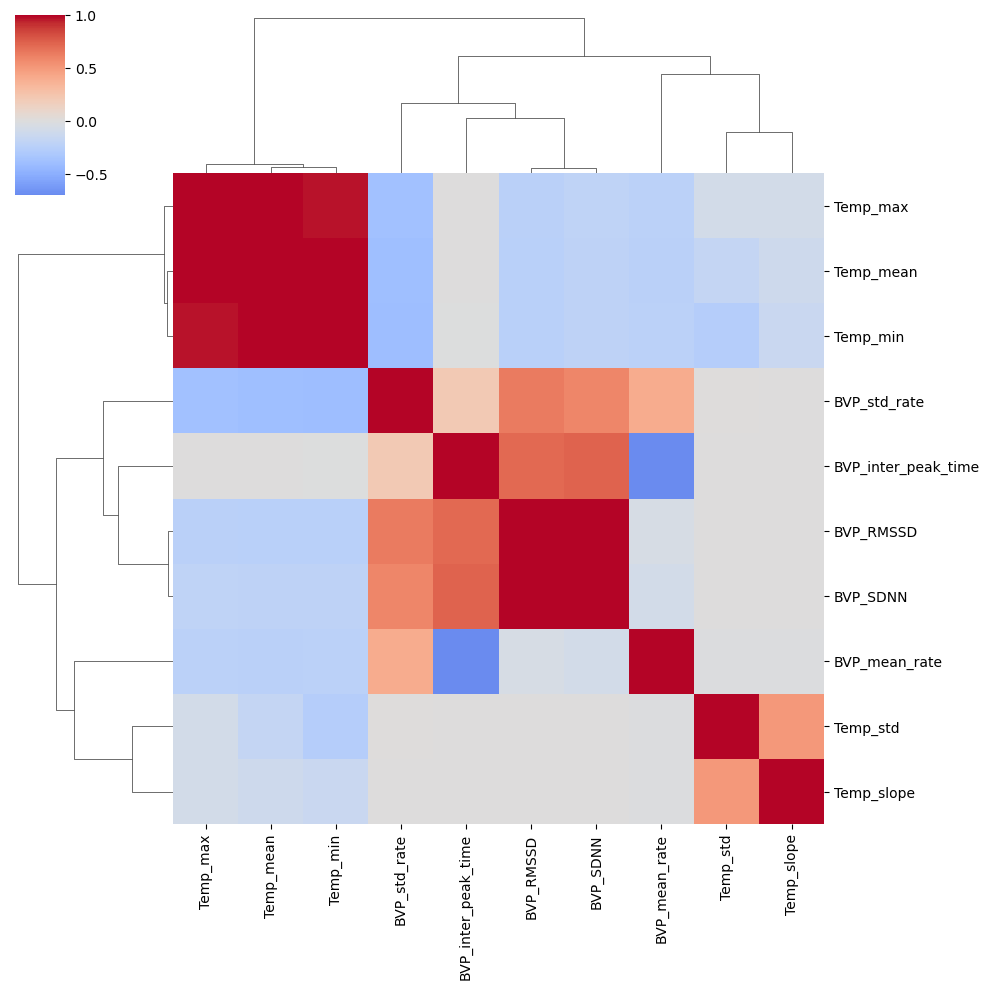

In [16]:
sns.clustermap(corr, cmap='coolwarm', center=0)

## Testing basic models with all features

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [39]:
def evaluate_performance(train_df, test_data_list, method, window_in_sec=60, shift_in_sec=30):
    feature_cols = [c for c in train_df.columns if c not in ['label']]
    X_train = train_df[feature_cols].values
    y_train = train_df['label'].values

    if method == 'LR':
        model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=500, C=10.0)
    elif method == 'RF':
        model = RandomForestClassifier(n_estimators=30, class_weight="balanced", random_state=42)
    elif method == 'LDA':
        model = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
    else:
        print('Method not supported')
        return
        

    model.fit(X_train, y_train)

    for test_df in test_data_list:
        y_pred = model.predict(test_df[feature_cols].values)
        y_true = test_df['label'].values
        y_prob = model.predict_proba(test_df[feature_cols].values)[:,1] if hasattr(model, "predict_proba") else model.decision_function(test_df[feature_cols].values)
        # print(f'F1_score: {f1_score(y_true, y_pred)}')
        print(f'AUC: {roc_auc_score(y_true, y_prob)}')
        print('Classification report:\n', classification_report(y_true, y_pred, digits=3))
        get_detection_delay(y_true, y_pred, window_in_sec, shift_in_sec)

In [63]:
def get_detection_delay(y_true, y_pred, window_in_sec, shift_in_sec, threshold=3):
    output_true = np.convolve(y_true, np.ones(threshold), mode='valid')
    output_pred = np.convolve(y_pred, np.ones(threshold), mode='valid')
    false_alarms = 0
    start_idx = -1
    detection_idx = -1
    false_alarm_flag = False

    for i in range(len(output_true)):
        if start_idx < 0 and output_true[i] == threshold:
            start_idx = i

        if output_pred[i] == threshold:
            if output_true[i] == threshold:
                detection_idx = i
                break
            else:
                if not false_alarm_flag:
                    false_alarms += 1
                    false_alarm_flag = True
        else:
            false_alarm_flag = False

    if detection_idx >= 0:
        detection_delay = threshold*window_in_sec - (threshold-1)*(window_in_sec - shift_in_sec) + (detection_idx - start_idx)*shift_in_sec
        print(f'Stress onset was detected with a delay of {detection_delay} sec and with {false_alarms} false alarms.')
    else:
        print('No stress was detected')

#### Logistic Regression 

In [64]:
evaluate_performance(train_df_chest, test_data_list_chest, 'LR', 30, 15)

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        58
           1      1.000     1.000     1.000        44

    accuracy                          1.000       102
   macro avg      1.000     1.000     1.000       102
weighted avg      1.000     1.000     1.000       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 0.6363636363636365
Classification report:
               precision    recall  f1-score   support

           0      0.699     1.000     0.823        58
           1      1.000     0.432     0.603        44

    accuracy                          0.755       102
   macro avg      0.849     0.716     0.713       102
weighted avg      0.829     0.755     0.728       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1

In [42]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'LR')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.857     0.923        28
           1      0.840     1.000     0.913        21

    accuracy                          0.918        49
   macro avg      0.920     0.929     0.918        49
weighted avg      0.931     0.918     0.919        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.20578231292517007
Classification report:
               precision    recall  f1-score   support

           0      0.591     0.929     0.722        28
           1      0.600     0.143     0.231        21

    accuracy                          0.592        49
   macro avg      0.595     0.536     0.476        49
weighted avg      0.595     0.592     0.512        49

No stress was detected
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000 

#### Random Forests 

In [66]:
evaluate_performance(train_df_chest, test_data_list_chest, 'RF', 30, 15)

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.983     0.991        58
           1      0.978     1.000     0.989        44

    accuracy                          0.990       102
   macro avg      0.989     0.991     0.990       102
weighted avg      0.990     0.990     0.990       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      0.967     1.000     0.983        58
           1      1.000     0.955     0.977        44

    accuracy                          0.980       102
   macro avg      0.983     0.977     0.980       102
weighted avg      0.981     0.980     0.980       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.983     0.991 

In [44]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'RF')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.929     0.963        28
           1      0.913     1.000     0.955        21

    accuracy                          0.959        49
   macro avg      0.957     0.964     0.959        49
weighted avg      0.963     0.959     0.959        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.929     0.96

#### Linear Discriminant Analysis

In [67]:
evaluate_performance(train_df_chest, test_data_list_chest, 'LDA', 30, 15)

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      0.983     1.000     0.991        58
           1      1.000     0.977     0.989        44

    accuracy                          0.990       102
   macro avg      0.992     0.989     0.990       102
weighted avg      0.990     0.990     0.990       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 0.5039184952978056
Classification report:
               precision    recall  f1-score   support

           0      0.620     0.983     0.760        58
           1      0.900     0.205     0.333        44

    accuracy                          0.647       102
   macro avg      0.760     0.594     0.547       102
weighted avg      0.741     0.647     0.576       102

Stress onset was detected with a delay of 60 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1

In [46]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'LDA')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.7125850340136054
Classification report:
               precision    recall  f1-score   support

           0      0.700     1.000     0.824        28
           1      1.000     0.429     0.600        21

    accuracy                          0.755        49
   macro avg      0.850     0.714     0.712        49
weighted avg      0.829     0.755     0.728        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000    